In [14]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

2011-12-10 12:50:00


C:\Users\Raylin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Raylin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Raylin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

62
CustomerID
12346.0     3
12347.0    12
12348.0     8
12349.0    10
12350.0     4
Name: RFM_Score, dtype: int64
                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't Loose Them      25.2     195.1        4130.3  1690
Champions             62.7      57.0         974.7   467
Loyal                 78.8      39.7         724.2   447
Needs Attention      174.5      13.9         227.1   391
Potential             94.3      28.5         491.8   468
Promising            153.0      21.2         346.8   517
Require Activation   264.8       7.8         109.1   392


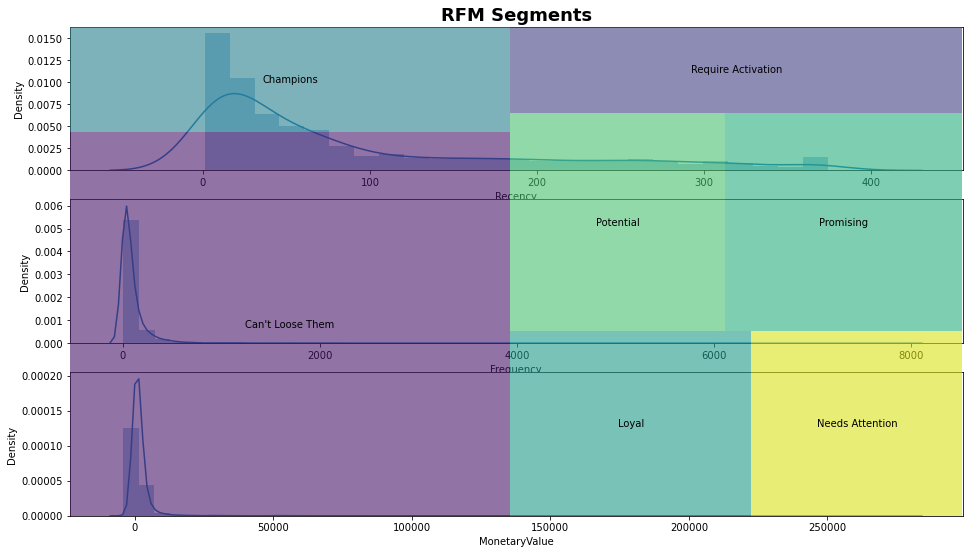

In [15]:

    # Read dataset
    online = pd.read_csv('data.csv', encoding = "ISO-8859-1")
    # Convert InvoiceDate from object to datetime format
    online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

    #print('{:,} rows; {:,} columns'.format(online.shape[0], online.shape[1]))
    #print('{:,} transactions don\'t have a customer id'.format(online[online.CustomerID.isnull()].shape[0]))
    #print('Transactions timeframe from {} to {}'.format(online['InvoiceDate'].min(),online['InvoiceDate'].max()))


    online.dropna()

    #Create TotalSum column for online dataset
    online['TotalSum'] = online['Quantity'] * online['UnitPrice']
    # Create snapshot date
    snapshot_date = online['InvoiceDate'].max() + timedelta(days=1)
    print(snapshot_date)# Grouping by CustomerID
    data_process = online.groupby(['CustomerID']).agg({
            'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
            'InvoiceNo': 'count',
            'TotalSum': 'sum'})
    # Rename the columns 
    data_process.rename(columns={'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)



    # print(data_process.head())
    # print('{:,} rows; {:,} columns'
    #       .format(data_process.shape[0], data_process.shape[1]))

    # Plot RFM distributions
    plt.figure(figsize=(12,10))# Plot distribution of R
    plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])# Plot distribution of F
    plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])# Plot distribution of M
    plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])# Show the plot
    #plt.show()


    # --Calculate R and F groups--# Create labels for Recency and Frequency
    r_labels = range(4, 0, -1); f_labels = range(1, 5)# Assign these labels to 4 equal percentile groups 
    r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)# Assign these labels to 4 equal percentile groups 
    f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)# Create new columns R and F 
    data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
    data_process.head()

    # Create labels for MonetaryValue
    m_labels = range(1, 5)# Assign these labels to three equal percentile groups 
    m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)# Create new column M
    data_process = data_process.assign(M = m_groups.values)


    # Concat RFM quartile values to create RFM Segments
    def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
    data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
    rfm = data_process
    rfm.head()


    # Count num of unique segments
    rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
    print(rfm_count_unique.sum())


    # Calculate RFM_Score
    rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
    print(rfm['RFM_Score'].head())


    # Define rfm_level function
    def rfm_level(df):
        if df['RFM_Score'] >= 9:
            return 'Can\'t Loose Them'
        elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
            return 'Champions'
        elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
            return 'Loyal'
        elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
            return 'Potential'
        elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
            return 'Promising'
        elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
            return 'Needs Attention'
        else:
            return 'Require Activation'# Create a new variable RFM_Level
    rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)# Print the header with top 5 rows to the console
    rfm.head()

    # Calculate average values for each RFM_Level, and return a size of each segment 
    rfm_level_agg = rfm.groupby('RFM_Level').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count']
    }).round(1)# Print the aggregated dataset
    print(rfm_level_agg)

    # Heatmap
    rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
    rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']#Create our plot and resize it.
    fig = plt.gcf()
    ax = fig.add_subplot()
    fig.set_size_inches(16, 9)
    squarify.plot(sizes=rfm_level_agg['Count'], 
                label=['Can\'t Loose Them',
                        'Champions',
                        'Loyal',
                        'Needs Attention',
                        'Potential', 
                        'Promising', 
                        'Require Activation'], alpha=.6 )
    plt.title("RFM Segments",fontsize=18,fontweight="bold")
    plt.axis('off')
    plt.show()